### EE 421/521 Image Processing - Spring 2020-21

## Project 4 - Frequency Domain Processing

#### Submission deadline: 29 March 2021

In this project, you will implement the following filters in the **Fourier** domain:

1. Ideal low-pass filter
2. Ideal high-pass filter
3. Ideal horizontal low-pass filter
4. Ideal horizontal high-pass filter

**This project will be graded for both EE 421 (HW3) and EE 521 (HW3) students.**

*Copyright (c) 2021 by Arif Tanju Erdem*

************************************
Neva Yaren Bulut
************************************

In [1]:
# STEP 0 Import the necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal
from scipy.linalg import circulant

# DFT calculations
from scipy import fftpack as ft

# mathematical calculations
import math
import cmath


In [2]:
# my function to set P to 0 if M infinitesmall
# (e.g., for setting phase to 0 when magnitude is infinitesmall)

def my_epsilon2zero(P, M):
    
    epsilon = 1.0e-6
    
    shapeP = P.shape
    shapeM = M.shape
    assert shapeP == shapeM
    
    P = P.reshape(-1)
    M = M.reshape(-1)

    for i in range(P.size):
        if M[i] < epsilon:
            P[i] = 0.0
            
    return P.reshape(shapeP)

# end of function

In [3]:
# my function to obtain a display-friendly version of 2-D DFT of an image
# (used for displaying DFT magnitude, DFT real part, and DFT imaginary part)

def my_log_display(X):
        
    shapeX = X.shape
    X = X.reshape(-1)

    for i in range(X.size):
        if X[i] < 0:
            # this is needed for real and imaginary parts
            X[i] = - np.log(1-X[i])
        else:
            # magnitude is always non-negative
            X[i] = np.log(1+X[i])
            
    return X.reshape(shapeX)

# end of function  

In [4]:
# my function to multiply an image with (-1)^(i+j) 
# so that the origin of its DFT is displayed at the center

def my_img_shift(img):
    
    height, width = img.shape
    assert height%2 == 0 and width%2 == 0
    
    img_shift = img.copy() + 0.0

    for i in range(height):
        for j in range(width):
            if (i+j)%2 == 1:
                img_shift[i,j] *= -1.0
                
    return img_shift

# end of function

In [5]:
# my function to round image data to nearest integer, then
# truncate to range [0, 255], and then set data type to uint8

def my_imgTruncate(img):
    
    img = np.round(img, 0)
    img = np.minimum(img, 255)
    img = np.maximum(img, 0)
    img = img.astype('uint8')
    
    return img

# end of function

In [6]:
# my function to construct a low/high-pass rectangular uniform mask

def my_mask_Rectangle(img_shape, mask_shape, isLowPass = True):
    
    assert len(img_shape) == 2 and len(mask_shape) == 2
    assert mask_shape < img_shape
    
    # height & width of image
    hi, wi = img_shape
    
    # height & width of mask
    hm, wm = mask_shape

    if isLowPass:
        # zero except at the center
        img_mask = np.zeros(img_shape)
        val = 1
    else:
        # one except at the center
        img_mask = np.ones(img_shape)
        val = 0
    
    # set the center value (1 for low pass, 0 for high pass)
    img_mask[(hi-hm)//2:(hi+hm)//2, (wi-wm)//2:(wi+wm)//2] = val

    return img_mask

# end of function

In [7]:
# my function to convert to lumincance, round to nearest integer, 
# truncate to range [0, 255], and then set data

def my_imgLuminance(imgRGB):
    
    # make sure it is a color image
    dim_img = imgRGB.shape[2]    
    assert dim_img >= 3
    
    # get the luminance data
    if dim_img == 3:
        imgLum = color.rgb2gray(imgRGB)
    else:
        # ignore the alpha channel
        imgLum = color.rgb2gray(imgRGB[:,:,0:3])

    imgLum = np.round(imgLum * 255, 0)
    imgLum = np.minimum(imgLum, 255)
    imgLum = np.maximum(imgLum, 0)
    imgLum = imgLum.astype('uint8')
    
    return imgLum

# end of function

Image width is 320 and image height is 512.
Image data type is uint8.



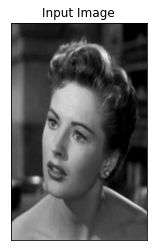

In [8]:
# STEP 1 Pick an image for filtering

# set image folder
image_folder = r'D:\yeni\Dersler\EE421-imageprocessing\images'

# read input image 
image_file = r'/hw4.jpg'
image_path = image_folder + image_file
imgRGB = io.imread(image_path)

if imgRGB.ndim >= 3:
    # color image
    # calculate the luminance image
    x_img = my_imgLuminance(imgRGB)
else:
    # monochrome image
    x_img = imgRGB

height = x_img.shape[0]
width = x_img.shape[1]
datatype = x_img.dtype

print("Image width is {} and image height is {}.".format(width, height))
print("Image data type is {}.\n".format(datatype))

# display luminance image
plt.imshow(x_img, cmap='gray', vmin=0, vmax=255)
plt.title('Input Image')
plt.xticks([]), plt.yticks([])
plt.show()

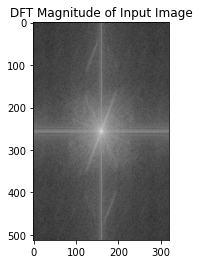

In [9]:
# STEP 2 Take the DFT of the image

# multiply the image with (-1)^(i+j) before DFT so that DFT origin is displayed at the center
# note that for this to work, both image width and height must be even
x_img_shift = my_img_shift(x_img)

# calculate the 2-D DFT via SciPy's 2-D DFT function
X_img_shift = ft.fft2(x_img_shift)

# get DFT size
height, width = X_img_shift.shape

# get a display friendly version for DFT magnitude
X_img_mag_pr = my_log_display(np.abs(X_img_shift))

# get min and max values for scaling during display
mag_max = X_img_mag_pr.max()
mag_min = X_img_mag_pr.min()

# display the DFT magnitude of the image
plt.imshow(X_img_mag_pr, cmap='gray')
plt.title('DFT Magnitude of Input Image')
plt.show()

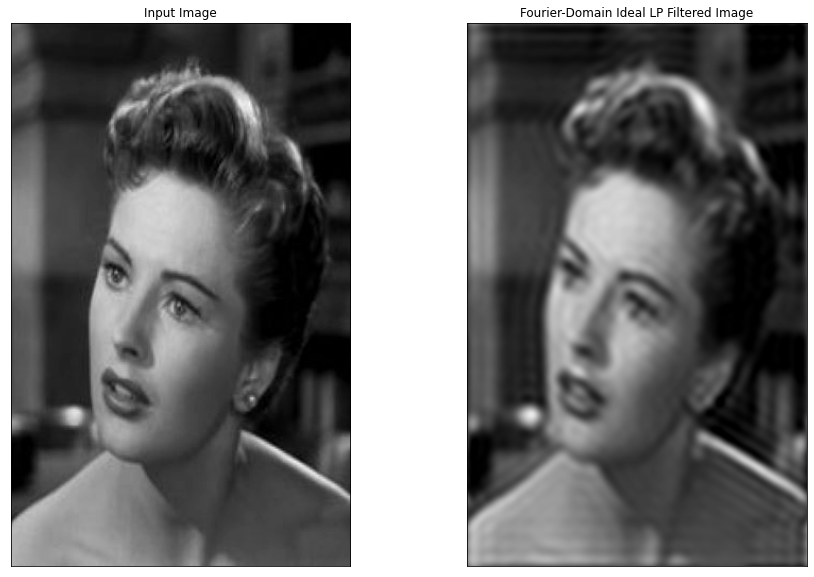

In [10]:
# STEP 3 Apply an ideal low-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal low-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

# ADD YOUR CODE BELOW

# set low-pass filter size (amount of low pass filtering) 
size_filter = 7
# define the mask size in the Fourier domain
mask_shape = (height//size_filter, width//size_filter) 
# construct the low-pass filter mask
filter_mask = my_mask_Rectangle(X_img_shift.shape, mask_shape, True)
# multiply with the low-pass filter mask
X_img_masked = X_img_shift * filter_mask


# calculate the IDFT and take the real part
img_filtered_Fourier_mean = ft.ifft2(X_img_masked).real

# multiply the image with (-1)^(i+j) after DFT to undo the shift
img_filtered_Fourier_mean = my_img_shift(img_filtered_Fourier_mean)

# round to nearest integer and set data type to integer
img_filtered_Fourier_mean = my_imgTruncate(img_filtered_Fourier_mean)


#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------

# ADD YOUR CODE HERE
# display original and filtered images
plt.figure(figsize=(15,10))
plt.subplot(121), plt.imshow(x_img, cmap = 'gray', vmin=0, vmax=255)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_filtered_Fourier_mean, cmap = 'gray', vmin=0, vmax=255)
plt.title('Fourier-Domain Ideal LP Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.close()

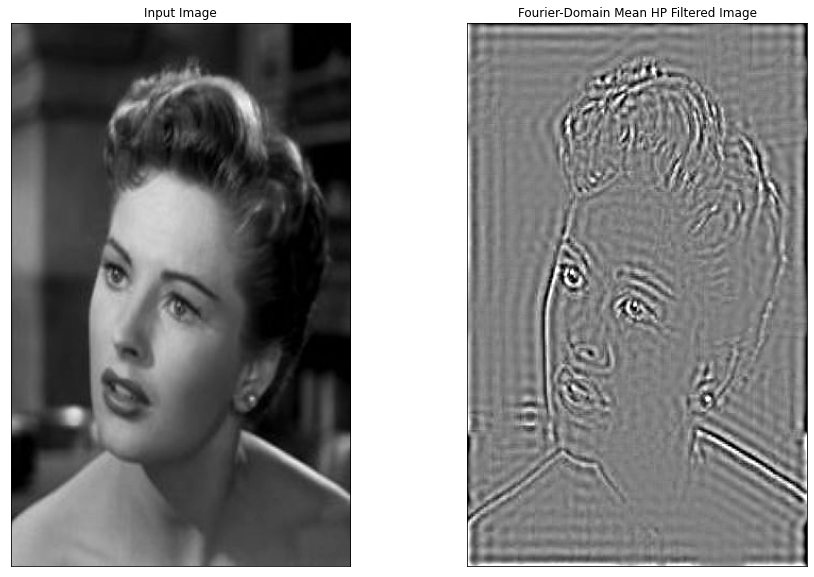

In [11]:
# STEP 4 Apply an ideal high-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal high-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# set high-pass filter size
size_filter = 7

# define the mask size based on DFT size and filter size
mask_shape = (height//size_filter, width//size_filter)

# construct the high-pass filter mask ("False" means HP mask)
filter_mask = my_mask_Rectangle(X_img_shift.shape, mask_shape, False)

# multiply with the filter mask
X_img_masked = X_img_shift * filter_mask

# calculate the IDFT and take the real part
img_filtered_Fourier_mean_HP = ft.ifft2(X_img_masked).real

# multiply the image with (-1)^(i+j) after DFT to undo the shift
img_filtered_Fourier_mean_HP = my_img_shift(img_filtered_Fourier_mean_HP)

# round to nearest integer and set data type to integer
img_filtered_Fourier_mean_HP = my_imgTruncate(img_filtered_Fourier_mean_HP * 4 + 128)

#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------

# ADD YOUR CODE HERE
plt.figure(figsize=(15,10))
plt.subplot(121), plt.imshow(x_img, cmap = 'gray', vmin=0, vmax=255)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_filtered_Fourier_mean_HP, cmap = 'gray', vmin=0, vmax=255)
plt.title('Fourier-Domain Mean HP Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.close()

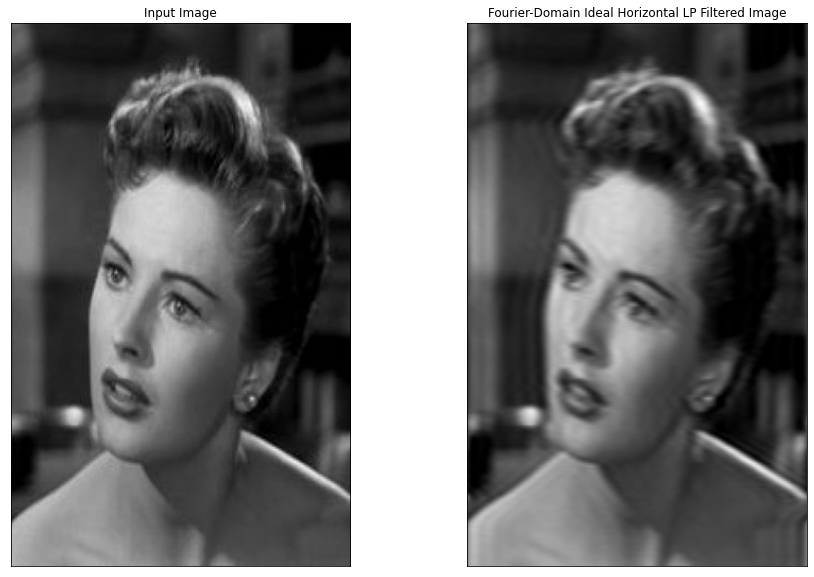

In [12]:
# STEP 5 Apply an ideal horizontal low-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal horizontal low-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# set low-pass filter size (amount of low pass filtering) 
size_filter = 7
# define the mask size in the Fourier domain
mask_shape = (height,width//size_filter)  #according to the given image,I picked the filter height equal to image's height.
# construct the low-pass filter mask      #Adjusted the filter's width to given filter size.
filter_mask = my_mask_Rectangle(X_img_shift.shape, mask_shape, True)
# multiply with the low-pass filter mask
X_img_masked = X_img_shift * filter_mask

# calculate the IDFT and take the real part
img_filtered_Fourier_mean = ft.ifft2(X_img_masked).real

# multiply the image with (-1)^(i+j) after DFT to undo the shift
img_filtered_Fourier_mean = my_img_shift(img_filtered_Fourier_mean)

# round to nearest integer and set data type to integer
img_filtered_Fourier_mean = my_imgTruncate(img_filtered_Fourier_mean)


#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------

# ADD YOUR CODE HERE
plt.figure(figsize=(15,10))
plt.subplot(121), plt.imshow(x_img, cmap = 'gray', vmin=0, vmax=255)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_filtered_Fourier_mean, cmap = 'gray', vmin=0, vmax=255)
plt.title('Fourier-Domain Ideal Horizontal LP Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.close()

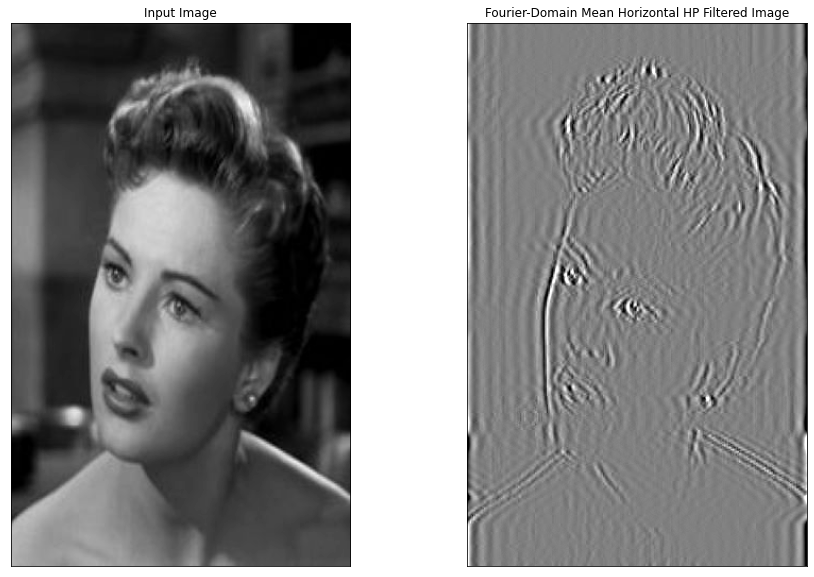

In [13]:
# STEP 6 Apply an ideal horizontal high-pass filter in the Fourier domain

#---------------------------------------------------------------
# 7:1 ideal horizontal high-pass filter implementation in the Fourier domain
#---------------------------------------------------------------

# ADD YOUR CODE BELOW
# set high-pass filter size
size_filter = 7

# define the mask size based on DFT size and filter size
mask_shape = (height, width//size_filter)

# construct the high-pass filter mask ("False" means HP mask)
filter_mask = my_mask_Rectangle(X_img_shift.shape, mask_shape, False)

# multiply with the filter mask
X_img_masked = X_img_shift * filter_mask


# calculate the IDFT and take the real part
img_filtered_Fourier_mean_HP = ft.ifft2(X_img_masked).real

# multiply the image with (-1)^(i+j) after DFT to undo the shift
img_filtered_Fourier_mean_HP = my_img_shift(img_filtered_Fourier_mean_HP)

# round to nearest integer and set data type to integer
img_filtered_Fourier_mean_HP = my_imgTruncate(img_filtered_Fourier_mean_HP * 4 + 128)


#---------------------------------------------------------------
# Display original and filtered image
#---------------------------------------------------------------

# ADD YOUR CODE HERE
plt.figure(figsize=(15,10))
plt.subplot(121), plt.imshow(x_img, cmap = 'gray', vmin=0, vmax=255)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_filtered_Fourier_mean_HP, cmap = 'gray', vmin=0, vmax=255)
plt.title('Fourier-Domain Mean Horizontal HP Filtered Image'), plt.xticks([]), plt.yticks([])
plt.show()
plt.close()

*STEP 7 Comments on the results*

*ADD YOUR COMMENTS HERE*

Comment on the results in Steps 3-6. Do they look as expected? Are there any ringing artefacts observed?

At ideal low-pass and high-pass filtering, we can see ringing artefacts in steps 3,4,5, and 6.